In [4]:
# =============================
# Colab Cell 1 — Setup, Hugging Face login, Drive Mount
# =============================

# Install required libraries:
!pip install -q datasets huggingface_hub tqdm scikit-learn onnxruntime

# Optional: install torch/torchvision if missing
# !pip install -q torch torchvision

# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Define project root inside Google Drive ---
import os
PROJECT_DIR = "/content/drive/MyDrive/trasnNet_task"
os.makedirs(PROJECT_DIR, exist_ok=True)

# Sub-directories for organization
os.makedirs(os.path.join(PROJECT_DIR, "models"), exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, "results"), exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, "checkpoints"), exist_ok=True)

print("Project root created at:", PROJECT_DIR)

# --- Hugging Face Login ---
from huggingface_hub import login

# Direct login with token
hf_token = ""
login(token=hf_token)

print("Hugging Face login successful (token accepted).")

# Note:
# - Models will be saved in /content/drive/MyDrive/trasnNet_task/models
# - Checkpoints for resume training in /content/drive/MyDrive/trasnNet_task/checkpoints
# - Results (CSV, confusion matrix, logs) in /content/drive/MyDrive/trasnNet_task/results


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project root created at: /content/drive/MyDrive/trasnNet_task
Hugging Face login successful (token accepted).


In [6]:
from datasets import load_dataset

# Loading TrashNet directly from Hugging Face
ds = load_dataset("garythung/trashnet")
print(ds)


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# =============================
# Colab Cell 2 — Stage 1: Dataset -> Dataloaders
# =============================

# Import standard libraries
import os
import numpy as np
from collections import Counter
from PIL import Image   # for image handling

# Import Hugging Face dataset loader
from datasets import load_dataset

# Import PyTorch Dataset and DataLoader utilities
from torch.utils.data import Dataset, DataLoader

# Import torchvision transforms for preprocessing & augmentation
from torchvision import transforms

# Import torch (core deep learning library)
import torch

# -----------------------------
# Configurations (Hyperparameters)
# -----------------------------
BATCH_SIZE = 16       # number of images per batch
IMAGE_SIZE = 224      # resize all images to 224x224 (common input size for CNNs)
NUM_WORKERS = 2       # number of worker threads for DataLoader (use 0 if Colab gives worker errors)

# -----------------------------
# Load dataset from Hugging Face Hub
# -----------------------------
print("Loading 'garythung/trashnet' from Hugging Face...")
ds_full = load_dataset("garythung/trashnet")  # dataset gets cached locally in ~/.cache/huggingface/datasets
print(ds_full)

# -----------------------------
# Train/Val/Test split
# -----------------------------
print("Splitting into train (70%), val (20%), test (10%) ...")

# Step 1: split full dataset into 70% train and 30% temp
split1 = ds_full["train"].train_test_split(test_size=0.3, seed=42)

# Step 2: split the 30% temp into validation and test (approx 20% and 10% overall)
split2 = split1["test"].train_test_split(test_size=0.33, seed=42)

# Final dictionary of splits
dataset = {
    "train": split1["train"],  # 70%
    "val": split2["train"],    # 20%
    "test": split2["test"]     # 10%
}

# -----------------------------
# Get class names (labels)
# -----------------------------
label_names = ds_full["train"].features["label"].names
print("Class names:", label_names)

# -----------------------------
# Define data augmentations (for training) and preprocessing (for val/test)
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),     # resize to 224x224
    transforms.RandomHorizontalFlip(),               # random flip for augmentation
    transforms.RandomRotation(10),                   # small random rotations
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),     # random brightness/contrast changes
    transforms.ToTensor(),                           # convert to tensor (0-1 range)
    transforms.Normalize([0.485,0.456,0.406],        # normalize with ImageNet mean
                         [0.229,0.224,0.225])        # normalize with ImageNet std
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),     # resize
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# -----------------------------
# PyTorch Dataset wrapper for Hugging Face datasets
# -----------------------------
class HFDatasetTorch(Dataset):
    def __init__(self, hf_ds, transform=None):
        self.ds = hf_ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)   # return number of samples

    def __getitem__(self, idx):
        # Get one example from Hugging Face dataset
        ex = self.ds[idx]
        img = ex["image"]     # PIL Image or np.array
        label = ex["label"]   # class index

        # Ensure it's a PIL Image
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        img = img.convert("RGB")   # make sure it's 3-channel RGB

        # Apply transforms if provided
        if self.transform:
            img = self.transform(img)

        return img, label     # return transformed image + label

# -----------------------------
# Wrap Hugging Face dataset into PyTorch Datasets
# -----------------------------
train_ds = HFDatasetTorch(dataset["train"], transform=train_transform)
val_ds   = HFDatasetTorch(dataset["val"],   transform=val_transform)
test_ds  = HFDatasetTorch(dataset["test"],  transform=val_transform)

# -----------------------------
# Create PyTorch DataLoaders
# -----------------------------
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# -----------------------------
# Sanity checks
# -----------------------------
print(f"Sizes -> train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")
print("Class distribution in train:", Counter(dataset["train"]["label"]))

# Show one batch of data to verify shapes
imgs, labs = next(iter(train_loader))
print("One batch images.shape:", imgs.shape, "labels.shape:", labs.shape)
print("Sample labels:", labs[:12].tolist())

# -----------------------------
# Expose variables to global scope (for later cells)
# -----------------------------
globals().update({
    "label_names": label_names,   # list of class names
    "train_loader": train_loader,
    "val_loader": val_loader,
    "test_loader": test_loader,
    "dataset_splits": dataset
})


Loading 'garythung/trashnet' from Hugging Face...
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})
Splitting into train (70%), val (20%), test (10%) ...
Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Sizes -> train: 3537, val: 1016, test: 501
Class distribution in train: Counter({3: 821, 1: 705, 4: 647, 2: 585, 0: 580, 5: 199})
One batch images.shape: torch.Size([16, 3, 224, 224]) labels.shape: torch.Size([16])
Sample labels: [2, 1, 3, 2, 4, 0, 4, 2, 3, 2, 4, 3]


In [10]:
# =============================
# Colab Cell 4 — Stage 2: Training (ResNet18 transfer learning, clean version)
# =============================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
from tqdm import tqdm   # for progress bars
from sklearn.metrics import precision_recall_fscore_support

# -----------------------------
# Configuration
# -----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, else CPU
EPOCHS = 3                  # number of training epochs (adjustable) #keeping 3 as i don't have colab cerdits right now
LEARNING_RATE = 1e-4        # learning rate for optimizer
MODELS_DIR = "/content/trasnNet_task/models"  # directory to save models
os.makedirs(MODELS_DIR, exist_ok=True)  # create directory if it does not exist

# -----------------------------
# Build ResNet18 model
# -----------------------------
num_classes = len(label_names)  # number of classes in dataset

# Load ResNet18 with pretrained ImageNet weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Optionally freeze backbone layers to speed up training:
# for param in model.parameters():
#     param.requires_grad = False

# Replace the final fully connected (fc) layer with a new one for our number of classes
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# Move model to GPU/CPU
model = model.to(DEVICE)

# -----------------------------
# Define Loss, Optimizer, Scheduler
# -----------------------------
criterion = nn.CrossEntropyLoss()                        # classification loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Adam optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(        # learning rate scheduler
    optimizer,
    mode="max",      # maximize validation accuracy
    factor=0.5,      # reduce LR by half on plateau
    patience=2       # wait 2 epochs before reducing
)

# -----------------------------
# Training loop
# -----------------------------
best_val_acc = 0.0  # track best validation accuracy
history = {"train_loss": [], "val_loss": [], "val_acc": []}  # log losses and accuracy

for epoch in range(1, EPOCHS + 1):
    # -------- Train phase --------
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch} train"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)    # move data to device
        optimizer.zero_grad()                                # reset gradients
        outputs = model(imgs)                                # forward pass
        loss = criterion(outputs, labels)                    # compute loss
        loss.backward()                                      # backpropagate
        optimizer.step()                                     # update weights
        running_loss += loss.item() * imgs.size(0)           # accumulate loss

    # Average training loss for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    history["train_loss"].append(epoch_loss)

    # -------- Validation phase --------
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():  # no gradient computation during validation
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)  # predicted class
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Average validation loss and accuracy
    val_loss /= len(val_loader.dataset)
    val_acc = correct / total
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Step the scheduler with the new validation accuracy
    scheduler.step(val_acc)

    # Report progress
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save model checkpoint if it improves validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = os.path.join(MODELS_DIR, "resnet18_best.pth")
        torch.save({
            "model_state": model.state_dict(),
            "label_names": label_names
        }, save_path)
        print("Saved new best model ->", save_path)

# -----------------------------
# Training finished
# -----------------------------
print("Training complete. Best validation accuracy:", best_val_acc)


Epoch 1 train:   0%|          | 1/222 [00:03<14:31,  3.94s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3bc099a7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3bc099a7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/pyt

Epoch 1/3 | Train Loss: 0.6267 | Val Loss: 0.3616 | Val Acc: 0.8750
Saved new best model -> /content/trasnNet_task/models/resnet18_best.pth


Epoch 2 train:   1%|          | 2/222 [00:03<06:17,  1.72s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3bc099a7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3bc099a7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/pyt

KeyboardInterrupt: 

In [11]:
!pip install onnx onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 123.2 MB/s eta 0:00:00


In [13]:
# =============================
# Colab Cell 5 — Stage 3: Export to TorchScript & ONNX
# =============================

import torch
import os
from torchvision.models import resnet18, ResNet18_Weights

# -----------------------------
# Define model file paths
# -----------------------------
MODELS_DIR = "/content/trasnNet_task/models"
best_model_path = os.path.join(MODELS_DIR, "resnet18_best.pth")           # trained checkpoint
torchscript_path = os.path.join(MODELS_DIR, "resnet18_scrap_scripted.pt") # TorchScript export file
onnx_path = os.path.join(MODELS_DIR, "resnet18_scrap.onnx")               # ONNX export file

# -----------------------------
# Load the trained checkpoint
# -----------------------------
checkpoint = torch.load(best_model_path, map_location="cpu")  # load trained model weights and metadata
label_names = checkpoint.get("label_names", label_names)      # retrieve label names
num_classes = len(label_names)                                # determine number of output classes

# -----------------------------
# Rebuild the model architecture
# -----------------------------
# Note: We load ResNet18 without pretrained weights (weights=None),
# because we only need the structure to load our trained weights.
model_cpu = resnet18(weights=None)

# Replace the final classification layer with correct output size
model_cpu.fc = torch.nn.Linear(model_cpu.fc.in_features, num_classes)

# Load the trained parameters into the architecture
model_cpu.load_state_dict(checkpoint["model_state"])
model_cpu.eval()  # set model to evaluation mode

# -----------------------------
# Export model to TorchScript
# -----------------------------
# Create a dummy input tensor of correct shape (1 image, 3 channels, 224x224)
example_input = torch.randn(1, 3, 224, 224)

# Trace the model with example input to produce a TorchScript graph
scripted_model = torch.jit.trace(model_cpu, example_input)

# Save the TorchScript model
scripted_model.save(torchscript_path)
print("TorchScript model saved at:", torchscript_path)

# -----------------------------
# Export model to ONNX
# -----------------------------
torch.onnx.export(
    model_cpu,                # model
    example_input,            # dummy input
    onnx_path,                # output file path
    input_names=["input"],    # name of input tensor
    output_names=["output"],  # name of output tensor
    dynamic_axes={            # allow variable batch size
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    },
    opset_version=11          # ONNX opset version
)

print("ONNX model saved at:", onnx_path)


TorchScript model saved at: /content/trasnNet_task/models/resnet18_scrap_scripted.pt


/tmp/ipython-input-67104762.py:54: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


ONNX model saved at: /content/trasnNet_task/models/resnet18_scrap.onnx


In [14]:
# =============================
# Colab Cell 6 — Stage 3: Inference Test (TorchScript + ONNX)
# =============================

import torch
import onnxruntime as ort
import numpy as np
from torchvision import transforms
from PIL import Image

# -----------------------------
# Paths to exported models
# -----------------------------
torchscript_path = "/content/trasnNet_task/models/resnet18_scrap_scripted.pt"
onnx_path = "/content/trasnNet_task/models/resnet18_scrap.onnx"

# -----------------------------
# Define preprocessing pipeline
# -----------------------------
# Must be identical to validation/test transforms:
# - Resize to 224x224
# - Convert to tensor
# - Normalize with ImageNet mean and std
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# -----------------------------
# TorchScript Inference
# -----------------------------
def predict_torchscript(img_path, topk=1):
    # Load the TorchScript model
    model = torch.jit.load(torchscript_path).eval()

    # Load image and convert to RGB
    img = Image.open(img_path).convert("RGB")

    # Apply preprocessing and add batch dimension
    x = preprocess(img).unsqueeze(0)  # shape [1, 3, 224, 224]

    # Forward pass through the model (no gradients needed)
    with torch.no_grad():
        out = model(x)
        # Apply softmax to convert logits to probabilities
        probs = torch.nn.functional.softmax(out, dim=1).cpu().numpy()[0]

    # Get top-k predictions
    top_idx = np.argsort(probs)[-topk:][::-1]
    return [(label_names[i], float(probs[i])) for i in top_idx]

# -----------------------------
# ONNX Inference
# -----------------------------
def predict_onnx(img_path, topk=1):
    # Create ONNX inference session (CPU backend by default)
    sess = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])

    # Load image and preprocess
    img = Image.open(img_path).convert("RGB")
    x = preprocess(img).unsqueeze(0).numpy().astype(np.float32)  # convert to numpy float32

    # Run inference with ONNX
    out = sess.run(None, {"input": x})

    # Apply softmax manually (since ONNX export gives raw logits)
    probs = np.exp(out[0]) / np.sum(np.exp(out[0]), axis=1, keepdims=True)
    probs = probs[0]

    # Get top-k predictions
    top_idx = probs.argsort()[-topk:][::-1]
    return [(label_names[i], float(probs[i])) for i in top_idx]

# -----------------------------
# Test Inference on a Sample Image
# -----------------------------
# Select the first test sample from dataset_splits
sample_img = dataset_splits["test"][0]["image"]

# Save it temporarily so we can load it again for inference
sample_path = "/content/sample_test.jpg"
sample_img.save(sample_path)

# Run inference using both TorchScript and ONNX
print("TorchScript prediction:", predict_torchscript(sample_path))
print("ONNX prediction:", predict_onnx(sample_path))


TorchScript prediction: [('trash', 0.9489697813987732)]
ONNX prediction: [('trash', 0.948969841003418)]


In [18]:
# =============================
# Colab Cell 7 — Stage 4: Conveyor Simulation
# =============================

import os
import csv
import time
from PIL import Image

# -----------------------------
# Results folder and CSV path
# -----------------------------
os.makedirs("/content/trasnNet_task/results", exist_ok=True)                 # create results directory if not present
csv_path = "/content/trasnNet_task/results/predictions.csv"                  # CSV file to log predictions

# -----------------------------
# Choose inference function
# -----------------------------
# can switch between TorchScript or ONNX depending on which export you want to test.
inference_fn = predict_torchscript   # or use: predict_onnx

# -----------------------------
# Simulation parameters
# -----------------------------
CONF_THRESHOLD = 0.60   # flag predictions below this probability as "low confidence"
FRAME_INTERVAL = 0.2    # delay between frames (seconds) to simulate real-time stream
# Limit to first 100 test images safely
MAX_FRAMES = 100
test_subset = dataset_splits["test"].select(range(MAX_FRAMES))

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["frame_id", "predicted_class", "confidence", "low_confidence_flag", "timestamp"])

    for i, ex in enumerate(test_subset):
        # load image
        img = ex["image"]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)

        # save temporary file for inference
        tmp_path = f"/tmp/frame_{i}.jpg"
        img.save(tmp_path)

        # run inference on the frame
        preds = inference_fn(tmp_path, topk=1)
        pred_class, conf = preds[0]

        # check confidence threshold
        low_conf = int(conf < CONF_THRESHOLD)

        # record current timestamp
        ts = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

        # print result to console
        print(f"Frame {i:03d}: {pred_class} ({conf*100:.2f}%) {'LOW CONFIDENCE' if low_conf else ''}")

        # write result to CSV
        writer.writerow([i, pred_class, f"{conf:.4f}", low_conf, ts])

        # simulate delay between frames
        time.sleep(FRAME_INTERVAL)

print(f"Simulation complete. Predictions saved to: {csv_path}")



Frame 000: trash (94.90%) 
Frame 001: trash (61.29%) 
Frame 002: glass (59.13%) LOW CONFIDENCE
Frame 003: cardboard (99.91%) 
Frame 004: paper (99.89%) 
Frame 005: paper (98.32%) 
Frame 006: plastic (50.50%) LOW CONFIDENCE
Frame 007: plastic (99.11%) 
Frame 008: paper (95.13%) 
Frame 009: paper (82.85%) 
Frame 010: paper (99.55%) 
Frame 011: glass (98.54%) 
Frame 012: paper (99.98%) 
Frame 013: glass (99.63%) 
Frame 014: glass (99.12%) 
Frame 015: paper (97.75%) 
Frame 016: cardboard (99.88%) 
Frame 017: metal (81.05%) 
Frame 018: paper (98.09%) 
Frame 019: plastic (99.67%) 
Frame 020: glass (92.40%) 
Frame 021: paper (99.47%) 
Frame 022: paper (99.27%) 
Frame 023: paper (97.68%) 
Frame 024: cardboard (99.87%) 
Frame 025: paper (85.76%) 
Frame 026: plastic (97.49%) 
Frame 027: plastic (81.63%) 
Frame 028: cardboard (99.99%) 
Frame 029: cardboard (99.99%) 
Frame 030: plastic (99.81%) 
Frame 031: plastic (90.43%) 
Frame 032: paper (99.96%) 
Frame 033: plastic (97.83%) 
Frame 034: plastic

In [21]:
# =============================
# Colab Cell 7b — Stage 4: Conveyor Visualization (100 Images Grid)
# =============================

import matplotlib.pyplot as plt
import time
from PIL import Image
import os

# -----------------------------
# Choose inference backend
# -----------------------------
inference_fn = predict_torchscript  # or predict_onnx

# -----------------------------
# Visualization parameters
# -----------------------------
CONF_THRESHOLD = 0.60
FRAME_INTERVAL = 0.3   # shorter pause for smoother progress
NUM_IMAGES = 100        # total images to display
IMAGES_PER_ROW = 10     # number of images per row
ROWS = NUM_IMAGES // IMAGES_PER_ROW  # calculate rows automatically

# -----------------------------
# Collect predictions for first 100 samples
# -----------------------------
predictions = []

for i in range(NUM_IMAGES):
    ex = dataset_splits["test"][i]
    img = ex["image"]

    # ensure the image is a PIL Image
    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)

    # save temporarily for inference
    tmp_path = f"/tmp/frame_{i}.jpg"
    img.save(tmp_path)

    # run prediction
    preds = inference_fn(tmp_path, topk=1)
    pred_class, conf = preds[0]
    conf_text = f"{pred_class} ({conf*100:.1f}%)"
    if conf < CONF_THRESHOLD:
        conf_text += " ⚠️"

    predictions.append((img, conf_text))
    time.sleep(FRAME_INTERVAL)

# -----------------------------
# Display in a 10x10 grid
# -----------------------------
fig, axes = plt.subplots(ROWS, IMAGES_PER_ROW, figsize=(22, 22))
fig.suptitle("Conveyor Simulation: Predicted Classes & Confidence (100 Samples)", fontsize=18)

for i, (img, conf_text) in enumerate(predictions):
    ax = axes[i // IMAGES_PER_ROW, i % IMAGES_PER_ROW]
    ax.imshow(img)
    ax.set_title(conf_text, fontsize=8)
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.97])

# -----------------------------
# Save the grid visualization
# -----------------------------
os.makedirs("/content/trasnNet_task/results", exist_ok=True)
save_path = "/content/trasnNet_task/results/conveyor_grid_100.png"
plt.savefig(save_path, dpi=200)
plt.show()

print(f"Saved conveyor grid visualization at: {save_path}")


Output hidden; open in https://colab.research.google.com to view.

Classification Report:

              precision    recall  f1-score   support

   cardboard     0.9412    0.8533    0.8951        75
       glass     0.9072    0.8544    0.8800       103
       metal     0.7526    0.9359    0.8343        78
       paper     0.8947    0.8947    0.8947       114
     plastic     0.8866    0.8190    0.8515       105
       trash     0.6786    0.7308    0.7037        26

    accuracy                         0.8623       501
   macro avg     0.8435    0.8480    0.8432       501
weighted avg     0.8692    0.8623    0.8634       501



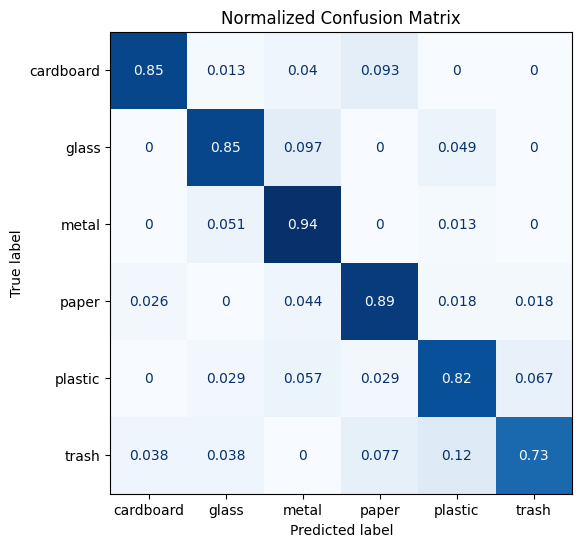

Confusion matrix saved at: /content/trasnNet_task/results/confusion_matrix.png


In [23]:
# =============================
# Colab Cell 8 — Stage 5: Reporting & Evaluation
# =============================

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os

# -----------------------------
# Ensure results folder exists
# -----------------------------
os.makedirs("/content/trasnNet_task/results", exist_ok=True)

# -----------------------------
# Load the best trained model
# -----------------------------
checkpoint = torch.load("/content/trasnNet_task/models/resnet18_best.pth", map_location=DEVICE)

# Rebuild model architecture (ResNet18 without pretrained weights)
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(label_names))

# Load trained weights
model.load_state_dict(checkpoint["model_state"])
model = model.to(DEVICE)
model.eval()   # set to evaluation mode

# -----------------------------
# Run inference on the test set
# -----------------------------
all_preds, all_labels = [], []
with torch.no_grad():   # no gradients during evaluation
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)                # forward pass
        preds = outputs.argmax(dim=1)        # predicted class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# -----------------------------
# Print classification metrics
# -----------------------------
print("Classification Report:\n")
print(classification_report(
    all_labels,
    all_preds,
    target_names=label_names,
    digits=4
))

# -----------------------------
# Plot and save confusion matrix
# -----------------------------
cm = confusion_matrix(all_labels, all_preds, normalize="true")   # normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Normalized Confusion Matrix")

# Save to results folder
cm_path = "/content/trasnNet_task/results/confusion_matrix.png"
plt.savefig(cm_path)
plt.show()

print("Confusion matrix saved at:", cm_path)


In [ ]:
!ls /content

models	results  sample_data  sample_test.jpg


In [ ]:
# Zip the entire /content folder
!zip -r /content/project_outputs.zip /content

# Download the zip file
from google.colab import files
files.download("/content/project_outputs.zip")


updating: content/ (stored 0%)
updating: content/.config/ (stored 0%)
updating: content/.config/logs/ (stored 0%)
updating: content/.config/logs/2025.10.01/ (stored 0%)
updating: content/.config/logs/2025.10.01/13.38.45.865829.log (deflated 57%)
updating: content/.config/logs/2025.10.01/13.37.47.440273.log (deflated 92%)
updating: content/.config/logs/2025.10.01/13.38.18.172679.log (deflated 58%)
updating: content/.config/logs/2025.10.01/13.38.46.667378.log (deflated 56%)
updating: content/.config/logs/2025.10.01/13.38.34.930571.log (deflated 58%)
updating: content/.config/logs/2025.10.01/13.38.28.883409.log (deflated 86%)
updating: content/.config/config_sentinel (stored 0%)
updating: content/.config/.last_opt_in_prompt.yaml (stored 0%)
updating: content/.config/active_config (stored 0%)
updating: content/.config/default_configs.db (deflated 98%)
updating: content/.config/configurations/ (stored 0%)
updating: content/.config/configurations/config_default (deflated 15%)
updating: conte

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
!sudo apt-get install tree -y



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (170 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 126675 files and directories currently install

In [25]:
!tree /content/trasnNet_task

/content/trasnNet_task
├── checkpoints
├── models
│   ├── resnet18_best.pth
│   ├── resnet18_scrap.onnx
│   └── resnet18_scrap_scripted.pt
└── results
    ├── confusion_matrix.png
    ├── conveyor_grid_100.png
    └── predictions.csv

3 directories, 6 files


In [26]:
import shutil
from google.colab import files

# Define your main project folder
project_path = "/content/trasnNet_task"
zip_path = "/content/trasnNet_task_backup.zip"

# Create a zip of the entire folder (recursively)
shutil.make_archive("/content/trasnNet_task_backup", 'zip', project_path)

# Download the zip file to your local machine
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import nbformat

# Path of your notebook in Google Drive
notebook_path = "/content/drive/MyDrive/Colab Notebooks/trash_net_script.ipynb"
cleaned_path = "/content/drive/MyDrive/Colab Notebooks/trash_net_script_clean.ipynb"

# Load and clean the notebook
with open(notebook_path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

for cell in nb.cells:
    if "metadata" in cell:
        # Remove any leftover widget state metadata that breaks GitHub rendering
        cell["metadata"].pop("widgets", None)

# Write the cleaned notebook
with open(cleaned_path, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print(f"✅ Cleaned notebook saved at: {cleaned_path}")
